<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/spectral_indices_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Indices in R

Spectral indices are mathematical formulas applied to the spectral bands of remote sensing or satellite imagery to extract specific information about the Earth's surface and its properties. These indices are valuable tools in remote sensing and are widely used for a variety of applications, including agriculture, forestry, land cover classification, environmental monitoring, and more.
In this lesson, we will learn how to calculate different types of spectral Indices using R.  We will calculate the following indices:


* Normalized Difference Vegetation Index (NDVI)

* Soil Adjusted Vegetation Index (SAVI)

* Modified Soil Adjusted Vegetation Index (MSAVI)

* Enhanced Vegetation Index (EVI)

* Two bands Enhanced Vegetation Index (EVI2)

* Normalized Difference Water Index (NDWI)

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314931 sha256=60513b1aaad6d331c23cda2ec003c1b724cae2672dc5b5ca7b7e442d4ba7ce30
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
library(devtools)
install_github("bleutner/RStoolbox")

### Load R packages

In [3]:
%%R
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(sf)
library(raster)
library(rgdal)
library(luna)
library(geodata)
library(tidyverse)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(tmap)
library(tmaptools)
library(gridExtra)


Attaching package: ‘tidyterra’



    filter




which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching package: ‘raster’



    select


plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-7, (SVN revision 1203)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.4.3, released 2022/04/22
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.2.1, January 1st, 2022, [PJ_VERSION: 821]
Pa

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks raster::extract(), terra::extract()
✖ dplyr::filter()  masks tidyterra::filter(), stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select(), tidyterra::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: ‘gridExtra’



    combine




### Data

We will use atmospheric-corrected surface reflectance of Landsat-9 bands (Level 2) that have been downloaded from ErathExplorer. This scene (path/row: 137/44) covers the central part of Bangladesh for 2023-02-27 and images can found [here](https://drive.google.com/drive/folders/1STEct_skeNFSNkLRFnI0rM8PyElIEz9D?usp=sharing).

We will calculate all indices for a area Bangladesh covering ten districts of the country.  First, we will crop all TIF images in "Scene" folder by the polygon shape file of the study area and  save them in "Clip" folder.

In [4]:
%%R
# aoi as SF
aoi.sf<-st_read("/content/drive/MyDrive/Data/DSM_AOI/aoi_dsm_UTM46N.shp")
# Input TIF folder
inputTIF<-"/content/drive/MyDrive/Data/DSM_AOI/Landsat/Level_02/Scene/LC09_L2SP_137044_20230227_20230308_02_T1"
# file names
ff<- list.files(inputTIF, pattern="\\.TIF$", full.names=F)
files<- list.files(inputTIF, pattern="\\.TIF$", full.names=TRUE)
# add output directory and output file names
clipData <- "/content/drive/MyDrive/Data/DSM_AOI/Landsat/Level_02/Clip/LC09_L2SP_137044_20230227_20230308_02_T1/"
clipTIF <- paste0(clipData, ff)
# read all TIF file, clip  and write them
for (f in 1:length(files)){
  r <- raster(files[f])
  rc <- crop(r, aoi.sf, mask=TRUE)
  rw <- writeRaster(rc,clipTIF[f],overwrite=TRUE)
}

Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/aoi_dsm_UTM46N.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 147887.9 ymin: 2524549 xmax: 222936 ymax: 2588583
Projected CRS: WGS 84 / UTM zone 46N + unknown


### Load bands

We will use blue (b2), red (b4), NIR (b5) and Shortwave Infra-red1 (SWIR1) bands to calculate above mentioned indices.


In [5]:
%%R
BLUE<- raster(paste0(clipData,"LC09_L2SP_137044_20230227_20230308_02_T1_SR_B2.TIF"))
RED<- raster(paste0(clipData,"LC09_L2SP_137044_20230227_20230308_02_T1_SR_B4.TIF"))
NIR<- raster(paste0(clipData,"LC09_L2SP_137044_20230227_20230308_02_T1_SR_B5.TIF"))
SWIR1<- raster(paste0(clipData,"LC09_L2SP_137044_20230227_20230308_02_T1_SR_B6.TIF"))

### Normalized Difference Vegetation Index

The Normalized Difference Vegetation Index (NDVI) is one of the most widely used spectral indices in remote sensing and is particularly valuable for assessing vegetation health and density. NDVI quantifies the presence and vigor of vegetation based on the contrast between the reflectance of visible and near-infrared (NIR) light. Here's how NDVI is calculated and its primary applications:

Formula for NDVI:

**NDVI = (NIR - Red) / (NIR + Red)**

Where:

-   **NIR (Near-Infrared):** Reflectance in the near-infrared portion of the electromagnetic spectrum (typically Landsat band 5 or Sentinel-2 band 8).

-   **Red:** Reflectance in the red portion of the spectrum (typically Landsat band 4 or Sentinel-2 band 4).

**Interpretation of NDVI Values:**

NDVI values range from -1 to 1, with different land cover types and conditions having distinct NDVI signatures:

-   **Negative Values:** Water bodies and non-vegetated surfaces usually result in negative NDVI values.

-   **Values Near 0:** Barren areas or very sparse vegetation may have NDVI values close to 0.

-   **Values Between 0 and 0.2:** Represents areas with limited or stressed vegetation.

-   **Values Between 0.2 and 0.5:** Typically correspond to grasslands, shrubs, and open canopies.

-   **Values Above 0.5:** Indicate healthy and dense vegetation, such as forests, croplands, and lush grasslands. Higher NDVI values often imply more vigorous and productive vegetation.

**Applications of NDVI:**

1.  **Vegetation Monitoring:** NDVI is used to assess the health, density, and distribution of vegetation across landscapes. It is a critical tool in agriculture for monitoring crop health and identifying stressed or disease-affected plants.

2.  **Land Cover Classification:** NDVI can be used to distinguish between different land cover types, such as forests, croplands, grasslands, and urban areas, in remote sensing image classification tasks.

3.  **Drought Monitoring:** NDVI can help detect early signs of drought stress in vegetation by tracking changes in vegetation vigor over time. It is used for drought assessment and mitigation.

4.  **Environmental Monitoring:** NDVI is employed in various environmental studies to assess the impact of land use changes, deforestation, and urban expansion on ecosystems and biodiversity.

5.  **Wildfire Detection:** NDVI can be used in wildfire detection and assessment. A significant drop in NDVI values in a specific area may indicate recent fire activity.

6.  **Natural Resource Management:** NDVI is valuable for managing natural resources like forests and rangelands, aiding in sustainable land use practices.

7.  **Climate Change Research:** NDVI time series data can be used to monitor long-term changes in vegetation patterns, which can be associated with climate change impacts.

8.  **Urban Planning:** NDVI can help urban planners identify green spaces and monitor the health of urban vegetation, contributing to urban green infrastructure planning.

NDVI is an essential tool for remote sensing analysts and researchers because it provides valuable insights into the state of vegetation and can be used for a wide range of applications, from agriculture and forestry to environmental monitoring and climate change studies.

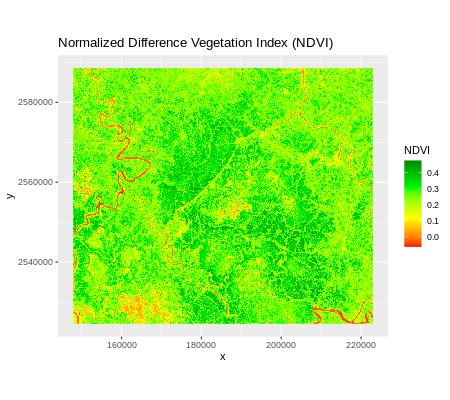

In [6]:
%%R -w 450 -h 400 -u px
# NDVI
NDVI = (NIR - RED)/(NIR +RED)
# Plot
ggR(NDVI, geom_raster = TRUE) +
	scale_fill_gradientn("NDVI",
	colours = c("red", "yellow", "green", "green4"))+
	ggtitle("Normalized Difference Vegetation Index (NDVI)")

### Soil Adjusted Vegetation Index

The Soil Adjusted Vegetation Index (SAVI) is an enhancement of the Normalized Difference Vegetation Index (NDVI) and is designed to reduce the impact of soil brightness variations on vegetation assessments, making it particularly useful in regions with varying soil types and conditions. SAVI was developed to accurately represent vegetation health and density by adjusting for soil background effects.

The formula for the Soil Adjusted Vegetation Index (SAVI) is as follows:

The Soil Adjusted Vegetation Index (SAVI) is a vegetation index used in remote sensing and satellite imagery analysis. SAVI is an enhancement of the Normalized Difference Vegetation Index (NDVI) and is designed to reduce the impact of soil brightness variations on vegetation assessments, making it particularly useful in regions with varying soil types and conditions. SAVI was developed to accurately represent vegetation health and density by adjusting for soil background effects.

The formula for the Soil Adjusted Vegetation Index (SAVI) is as follows:

**SAVI= (1 + L)*(NIR - RED)/(NIR + RED + L)**

Where:

-   **NIR (Near-Infrared):** Reflectance in the near-infrared portion of the electromagnetic spectrum (typically Landsat band 5 or Sentinel-2 band 8).

-   **Red:** Reflectance in the red portion of the spectrum (typically Landsat band 4 or Sentinel-2 band 4).

-   **L:** The soil adjustment factor, which can vary between -1 and 1.

The value of "L" is introduced to control the degree of soil adjustment. It allows users to customize SAVI based on the specific conditions of the study area. Positive values of "L" (typically ranging from 0.1 to 0.5) increase the soil correction effect, while negative values of "L" decrease it. The choice of "L" depends on factors such as soil type, vegetation type, and local conditions. In practice, values between 0.1 and 0.5 are often used.

**Interpretation of SAVI:**

Similar to NDVI, SAVI values typically range from -1 to 1, with different land cover types and conditions having distinct SAVI signatures:

-   **Negative Values:** Water bodies and non-vegetated surfaces usually result in negative SAVI values.

-   **Values Near 0:** Barren areas or very sparse vegetation may have SAVI values close to 0.

-   **Values Between 0 and 0.2:** Represents areas with limited or stressed vegetation.

-   **Values Between 0.2 and 0.5:** Typically correspond to grasslands, shrubs, and open canopies.

-   **Values Above 0.5:** Indicate healthy and dense vegetation, such as forests, croplands, and lush grasslands. Higher SAVI values often imply more vigorous and productive vegetation.

**Applications of SAVI:**

-   **Agriculture:** SAVI is used in agriculture to assess crop health and monitor vegetation vigor. It can help identify areas of stress or disease in crops.

-   **Environmental Studies:** SAVI is applied in environmental studies to evaluate the health of natural ecosystems, including forests, wetlands, and grasslands.

-   **Soil and Vegetation Interaction:** SAVI is valuable in regions with variable soil conditions where soil background can significantly affect vegetation assessments.

-   **Land Cover Classification:** SAVI can be used in land cover classification to distinguish between different vegetation types and land use classes.

-   **Drought Assessment:** SAVI can help detect early signs of drought stress in vegetation by providing a more accurate representation of vegetation health.

SAVI is a useful tool for remote sensing analysts and researchers, especially when soil variations need to be considered in vegetation assessments. It provides a more robust measure of vegetation health than NDVI alone in areas with diverse soil characteristics.

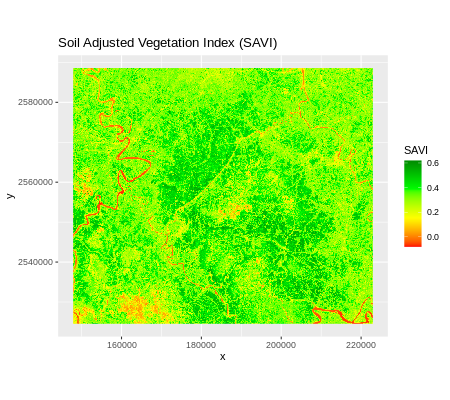

In [7]:
%%R -w 450 -h 400 -u px

L=0.3
SAVI= (1 + L)*(NIR - RED)/(NIR + RED + L)

ggR(SAVI, geom_raster = TRUE) +
   scale_fill_gradientn("SAVI", colours = c("red", "yellow", "green", "green4"))+
   ggtitle("Soil Adjusted Vegetation Index (SAVI)")

### Modified Soil Adjusted Vegetation Index (MSAVI)

The Modified Soil-Adjusted Vegetation Index (MSAVI) is a variation of the Soil-Adjusted Vegetation Index (SAVI) designed to further improve vegetation assessment in remote sensing and satellite imagery analysis. MSAVI, like SAVI, addresses the influence of soil background effects on vegetation indices, making it particularly useful in regions with varying soil types and conditions. MSAVI aims to enhance the accuracy of vegetation health and density assessments.

The formula for the Modified Soil-Adjusted Vegetation Index (MSAVI) is as follows:

**MSAVI = (2 * NIR + 1 - sqrt((2 * NIR + 1)^2 - 8 * (NIR - RED))) / 2**

Where:

-   **NIR (Near-Infrared):** Reflectance in the near-infrared portion of the electromagnetic spectrum (typically Landsat band 5 or Sentinel-2 band 8).

-   **Red:** Reflectance in the red portion of the spectrum (typically Landsat band 4 or Sentinel-2 band 4).

MSAVI incorporates a slightly more complex formula compared to SAVI, with the introduction of the square root operation. This modification is intended to provide better soil background adjustment, especially in cases of high vegetation cover and where SAVI may not be as effective.

**Interpretation of MSAVI:**

Like NDVI and SAVI, MSAVI values typically range from -1 to 1, with different land cover types and conditions having distinct MSAVI signatures:

-   **Negative Values:** Water bodies and non-vegetated surfaces usually result in negative MSAVI values.

-   **Values Near 0:** Barren areas or very sparse vegetation may have MSAVI values close to 0.

-   **Values Between 0 and 0.2:** Represents areas with limited or stressed vegetation.

-   **Values Between 0.2 and 0.5:** Typically correspond to grasslands, shrubs, and open canopies.

-   **Values Above 0.5:** Indicate healthy and dense vegetation, such as forests, croplands, and lush grasslands. Higher MSAVI values often imply more vigorous and productive vegetation.

**Applications of MSAVI:**

-   **Agriculture:** MSAVI is used in agriculture to assess crop health, monitor vegetation vigor, and detect stressors or diseases in crops.

-   **Environmental Studies:** MSAVI is applied in environmental studies to evaluate the health of natural ecosystems, including forests, wetlands, and grasslands.

-   **Soil and Vegetation Interaction:** MSAVI is valuable in regions with variable soil conditions where soil background can significantly affect vegetation assessments.

-   **Land Cover Classification:** MSAVI can be used in land cover classification to distinguish between different vegetation types and land use classes.

-   **Drought Assessment:** MSAVI can help detect early signs of drought stress in vegetation by providing a more accurate representation of vegetation health, especially in regions with complex soil conditions.

MSAVI, with its enhanced soil background adjustment, offers a useful alternative to traditional vegetation indices, particularly when dealing with challenging soil-vegetation interactions in remote sensing analysis. It provides improved accuracy in assessing vegetation health and density.

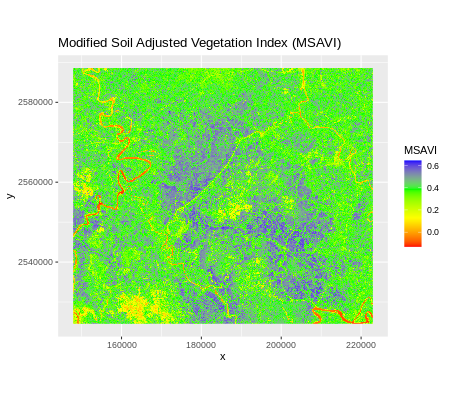

In [9]:
%%R -w 450 -h 400 -u px

MSAVI = (2 * NIR + 1 - sqrt((2 * NIR + 1)^2 - 8 * (NIR - RED))) / 2
ggR(MSAVI, geom_raster = TRUE) +
   scale_fill_gradientn("MSAVI", colours = c("red", "yellow", "green", "blue"))+
    ggtitle("Modified Soil Adjusted Vegetation Index (MSAVI)")

### Enhanced Vegetation Index (EVI)

The Enhanced Vegetation Index (EVI) is a vegetation index used in remote sensing and satellite imagery analysis to assess vegetation health, density, and overall vigor. EVI is an improvement over the Normalized Difference Vegetation Index (NDVI) and is designed to reduce atmospheric and soil background influences on vegetation assessments. EVI provides a more accurate representation of vegetation conditions, especially in areas with challenging environmental conditions.


EVI (Landsat 8-9) = 2.5 * ((NIR – RED) / (NIR + 6 * RED – 7.5 * BLUE + 1))


A two-band Enhanced Vegetation Index (EVI2) without the blue band reflectance has recently been developed as a proxy for the phenology, quantity, and activity of vegetation.

EVI2= 2.5 * (NIR - RED)/(NIR + 2.4 * RED + 1)


Where:

-   **NIR (Near-Infrared):** Reflectance in the near-infrared portion of the electromagnetic spectrum (typically Landsat band 5 or Sentinel-2 band 8).

-   **Red:** Reflectance in the red portion of the spectrum (typically Landsat band 4 or Sentinel-2 band 4).

-  **Blue:** Reflectance in the blue portion of the spectrum (typically Landsat band 3 or Sentinel-2 band 2).

The EVI formula includes multiple spectral bands (NIR and Red) to account for factors such as the aerosol scattering and canopy background variations that can affect NDVI. These adjustments enhance EVI's sensitivity to canopy structural variations and reduce the impact of atmospheric and soil background effects.

**Interpretation of EVI Values:**

EVI values typically range from -1 to 1, with different land cover types and conditions having distinct EVI signatures:

-   **Negative Values:** Water bodies and non-vegetated surfaces usually result in negative EVI values.

-   **Values Near 0:** Barren areas or very sparse vegetation may have EVI values close to 0.

-   **Values Between 0 and 0.2:** Represents areas with limited or stressed vegetation.

-   **Values Between 0.2 and 0.5:** Typically correspond to grasslands, shrubs, and open canopies.

-   **Values Above 0.5:** Indicate healthy and dense vegetation, such as forests, croplands, and lush grasslands. Higher EVI values often imply more vigorous and productive vegetation.

**Applications of EVI:**

-   **Vegetation Health Monitoring:** EVI is used to assess the health and density of vegetation, making it valuable in agriculture for monitoring crop health and identifying stressed or disease-affected plants.

-   **Environmental Studies:** EVI is applied in environmental studies to evaluate the health of natural ecosystems, including forests, wetlands, and grasslands.

-   **Land Cover Classification:** EVI can be used in land cover classification to distinguish between different vegetation types and land use classes.

-   **Drought Assessment:** EVI can help detect early signs of drought stress in vegetation by providing a more accurate representation of vegetation health.

-   **Urban Planning:** EVI can be used in urban planning to monitor the health of urban vegetation and contribute to urban green infrastructure planning.

EVI is a valuable tool in remote sensing analysis, offering improved sensitivity to vegetation conditions and reduced sensitivity to atmospheric and soil background effects compared to NDVI. It is widely used in various applications to assess and monitor vegetation health and density.

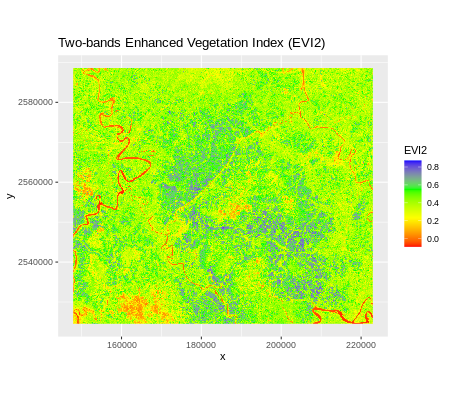

In [10]:
%%R -w 450 -h 400 -u px

EVI2= 2.5 * (NIR - RED)/(NIR + 2.4 * RED + 1)

ggR(EVI2, geom_raster = TRUE) +
   scale_fill_gradientn("EVI2", colours = c("red", "yellow", "green", "blue"))+
   ggtitle("Two-bands Enhanced Vegetation Index (EVI2)")



### Normalized Difference Water Index

The Normalized Difference Water Index (NDWI) is a vegetation index used in remote sensing and satellite imagery analysis to detect the presence and changes in surface water bodies. NDWI is particularly useful for mapping and monitoring water features such as lakes, rivers, reservoirs, and wetlands. It is sensitive to the absorption and scattering properties of liquid water, making it a valuable tool in hydrology, environmental monitoring, and land cover classification.

The formula for the Normalized Difference Water Index (NDWI) is as follows:

**NDWI = (NIR - SWIR) / (NIR + SWIR1)**

Where:

-   **NIR (Near-Infrared):** Reflectance in the near-infrared portion of the electromagnetic spectrum (typically Landsat band 5 or Sentinel-2 band 8).

-   **SWIR1 (Shortwave Infrared1):** Reflectance in the shortwave infrared portion of the spectrum (typically Landsat band 6 or Sentinel-2 band 11).

**Interpretation of NDWI Values:**

NDWI values typically range from -1 to 1, with different land cover types and conditions having distinct NDWI signatures:

-   **Negative Values:** Typically represent non-vegetated surfaces, such as bare soil or urban areas.

-   **Values Near 0:** Can indicate sparse or stressed vegetation.

-   **Positive Values:** Generally represent surface water bodies and healthy vegetation. The higher the positive NDWI value, the more likely it corresponds to water.

NDWI is particularly effective at highlighting the presence of water bodies because liquid water absorbs radiation in the shortwave infrared range, resulting in a strong contrast with the near-infrared reflectance.

**Applications of NDWI:**

-   **Water Detection:** NDWI is used to detect the presence of surface water bodies, including lakes, rivers, reservoirs, ponds, and wetlands.

-   **Change Detection:** NDWI time series analysis can be used to monitor changes in water extent over time, making it valuable for assessing water-related phenomena like seasonal variations, droughts, and floods.

-   **Wetland Mapping:** NDWI is used in wetland mapping and classification, aiding in wetland conservation and management.

-   **Land Cover Classification:** NDWI can be employed in land cover classification to distinguish between water bodies and other land cover classes.

-   **Ecological Studies:** NDWI is applied in ecological studies to understand the impact of water availability on ecosystems and habitats.

-   **Hydrological Modeling:** NDWI data can be integrated into hydrological models to estimate surface water dynamics, water volume, and runoff.

NDWI is a valuable tool for remote sensing analysts, hydrologists, and environmental scientists because it provides a straightforward means of identifying and monitoring surface water bodies using multispectral satellite imagery. It is widely used for various water-related applications and environmental assessments.

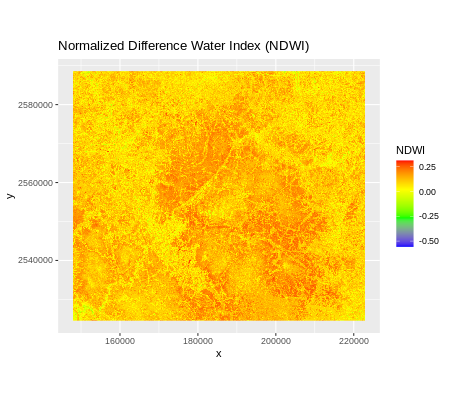

In [11]:
%%R -w 450 -h 400 -u px

NDWI=(NIR - SWIR1)/(NIR + SWIR1)

ggR(NDWI, geom_raster = TRUE) +
   	scale_fill_gradientn("NDWI",
	colours = c("blue", "green", "yellow", "red"))+
   	ggtitle("Normalized Difference Water Index (NDWI)")

### Further Reading

1. [Landsat Surface Reflectance-derived Spectral Indices](https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices)

2. 2. [List of spectral indices for Sentinel and Landsat](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)